# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 05**: Data pipeline with Neo4j

**Date**: October 2nd 2025

**Student Name**: Juan Alonso

**Professor**: Pablo Camarillo Ramirez

# Dataset description

The dataset describes all stations in the UK with routes trains take between each station.

Its important to note that some trains skip stations. For example, if a train visited stations A, B and C, and another train visited A and C, the path in a Graph Network should be A, B and C.

Frequency of routes through stations can be calculated, however, some routes have been obtained multiple times due detecting routes from different stations. Therefore, duplicate routes need to be taken into consideration.

# Data ingestion

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL - UK Train Stations") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "5")

In [3]:
from juanalonso.spark_utils import SparkUtils
from pyspark.sql.functions import col


columns_info = [
    ("source", "string"),
    ("target", "string"),
    ("distance", "double")
]

edges_schema = SparkUtils.generate_schema(columns_info)

base_path = "/opt/spark/work-dir/data/train_stations/"

edges_df = spark.read \
    .option("header", "true") \
    .schema(edges_schema) \
    .csv(base_path)

total_rows = edges_df.count()
distinct_sources = edges_df.select("source").distinct().count()
distinct_targets = edges_df.select("target").distinct().count()
distinct_stations = edges_df.select("source").union(edges_df.select("target")).distinct().count()

print("Total rows read:", total_rows)
print("Distinct sources:", distinct_sources)
print("Distinct targets:", distinct_targets)
print("Distinct stations (union):", distinct_stations)

Total rows read: 7636
Distinct sources: 2556
Distinct targets: 2556
Distinct stations (union): 2556


# Transformations

In [4]:
stations_df = edges_df.select(col("source").alias("name")).union(
    edges_df.select(col("target").alias("name"))
).distinct()

routes_df = edges_df.select(
    col("source"),
    col("target").alias("destination"),
    col("distance")
)

print("Routes preview:")
routes_df.show(5, truncate=False)

Routes preview:
+------+-----------+--------+
|source|destination|distance|
+------+-----------+--------+
|AAP   |BOP        |1.0     |
|AAP   |HRN        |1.43    |
|AAP   |NSG        |2.37    |
|AAP   |PAL        |2.38    |
|AAT   |ACN        |10.03   |
+------+-----------+--------+
only showing top 5 rows


# Writing Data in Neo4j

In [5]:
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

stations_df.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Station") \
    .option("node.keys", "name") \
    .save()

print(f"{stations_df.count()} station nodes wrote in Neo4j")

routes_df.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "CONNECTS") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":Station") \
    .option("relationship.source.save.mode", "match") \
    .option("relationship.source.node.keys", "source:name") \
    .option("relationship.target.labels", ":Station") \
    .option("relationship.target.save.mode", "match") \
    .option("relationship.target.node.keys", "destination:name") \
    .save()

print(f"{routes_df.count()} CONNECTS relationships wrote in Neo4j")

2556 station nodes wrote in Neo4j


7636 CONNECTS relationships wrote in Neo4j


# Read and Query Graphs with PySpark

In [7]:
# Add the code to read a data frame from Neo4J and run a simple query to verify 
from pyspark.sql.functions import col

sample_query_df = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query", """
        MATCH (a:Station)-[r:CONNECTS]->(b:Station)
        RETURN a.name AS source, b.name AS destination, r.distance AS distance
    """) \
    .load()

sample_query_df = sample_query_df.withColumn("distance", col("distance").cast("double"))

sample_query_df.orderBy(col("distance").desc()).limit(25).show(truncate=False)


+------+-----------+--------+
|source|destination|distance|
+------+-----------+--------+
|HFD   |AGV        |34.16   |
|BSK   |ADV        |28.9    |
|SAL   |ADV        |26.96   |
|ACN   |ACH        |18.94   |
|CWM   |AGV        |17.81   |
|PPL   |AGV        |13.21   |
|GYM   |ACL        |12.21   |
|WCH   |ADV        |11.11   |
|GRT   |ADV        |10.08   |
|STC   |ACH        |8.74    |
|BAG   |ACT        |4.74    |
|LGD   |ACL        |3.9     |
|MAO   |ACT        |3.39    |
|SNG   |ACT        |3.37    |
|CBS   |ADR        |2.85    |
|WIV   |ALR        |2.8     |
|CMH   |ABA        |2.5     |
|STM   |AIG        |2.1     |
|DRU   |ADR        |1.81    |
|COA   |ADR        |1.38    |
+------+-----------+--------+
only showing top 20 rows


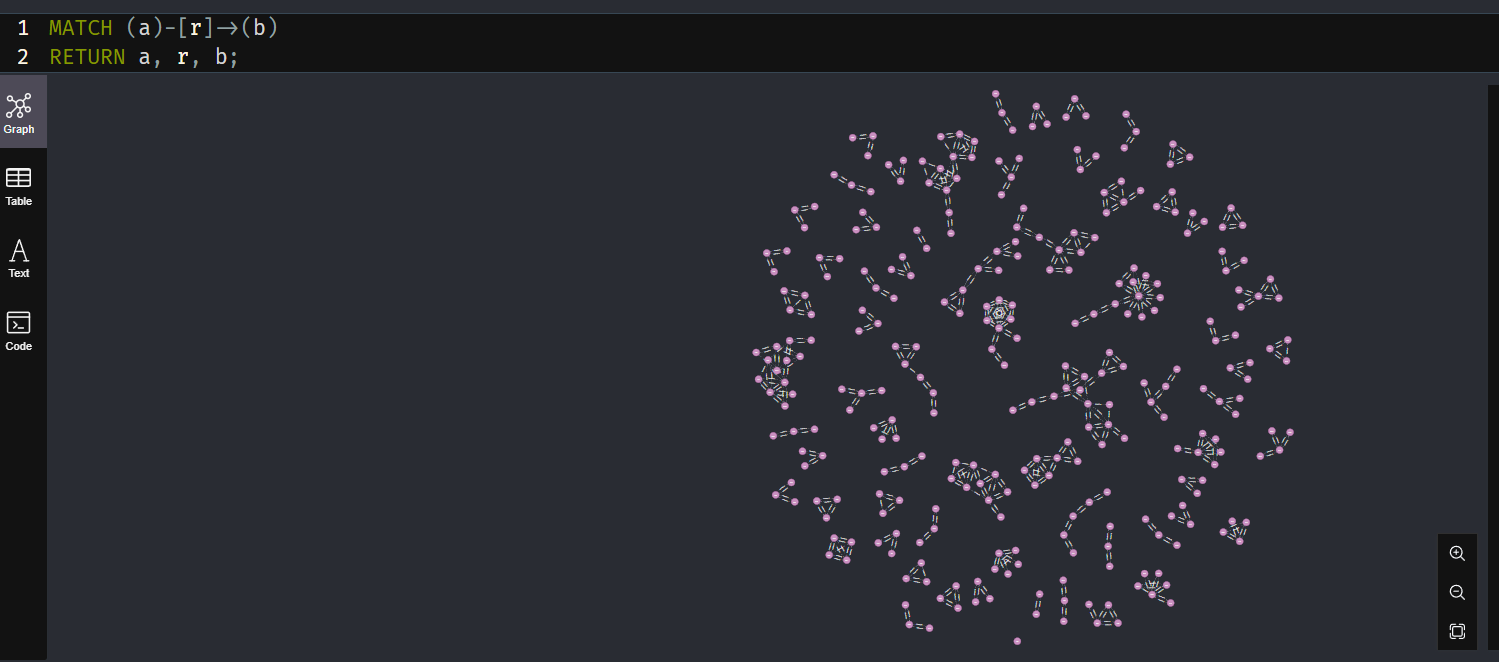

In [8]:
sc.stop()